We connect to google drive where the dataset has been stored


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We import the libraries that we are going to use

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization, Activation
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os

In [3]:
labels = ['anger','contempt','disgust','fear','happy','neutral','sad','surprise']

In [4]:
X_train = []
X_tune = []
y_train = []
y_tune = []

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Face_Emotion_Dataset','TRAIN',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Face_Emotion_Dataset','TUNE',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        X_tune.append(img)
        y_tune.append(i)

X_train = np.array(X_train)
X_tune = np.array(X_tune)
y_train = np.array(y_train)
y_tune = np.array(y_tune)
X_train = X_train/255
X_tune = X_tune/255

100%|██████████| 200/200 [00:02<00:00, 77.91it/s] 


In [5]:
X_train.shape

(8000, 128, 128, 3)

In [6]:
X_tune.shape

(1600, 128, 128, 3)

In [7]:
# Perform a stratified shuffle split to create a train-test split with 60% training data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
train_index, test_index = next(splitter.split(X_train, y_train))

X_train, X_test = X_train[train_index], X_train[test_index]
y_train, y_test = y_train[train_index], y_train[test_index]

# Perform another stratified shuffle split on the test set to create a test-validation split with 50% test data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
test_index, val_index = next(splitter.split(X_test, y_test))

X_test, X_val = X_test[test_index], X_test[val_index]
y_test, y_val = y_test[test_index], y_test[val_index]

In [8]:
X_train.shape

(4800, 128, 128, 3)

In [9]:
y_train.shape

(4800,)

In [10]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)
y_val = label_binarizer.fit_transform(y_val)
y_tune = label_binarizer.fit_transform(y_tune)

In [11]:
y_train.shape

(4800, 8)

In [12]:
generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
)

batch_size = 400

# Calculate the number of steps per epoch
steps_per_epoch = X_train.shape[0] // batch_size

data_iterator = generator.flow(X_train, y_train, batch_size=batch_size)

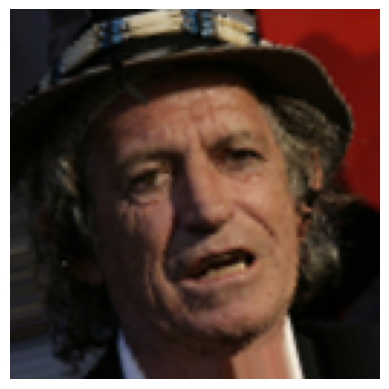

In [13]:
img = generator.flow(X_train, y_train, batch_size=20).next()

plt.imshow(img[0][0])
plt.axis("Off");
plt.show()

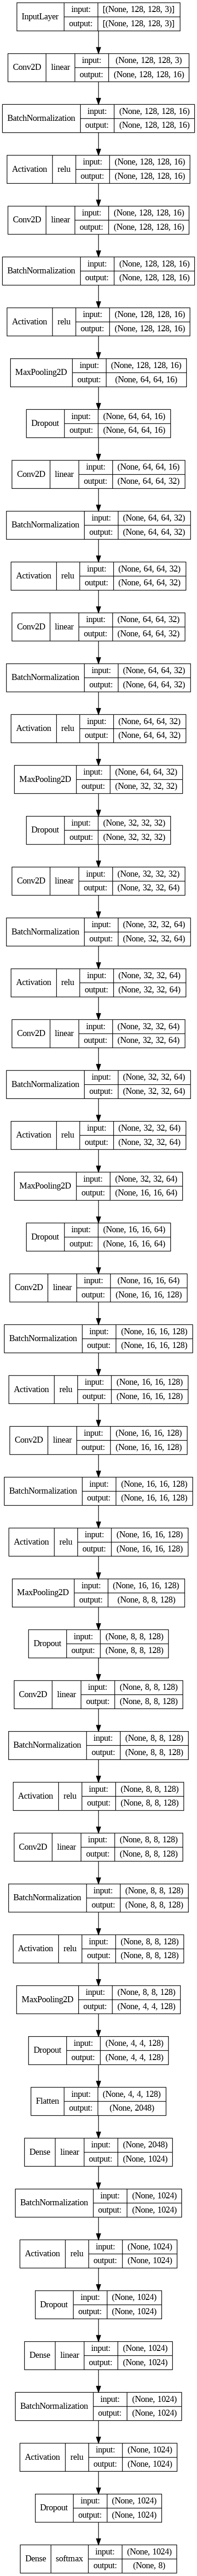

In [14]:
# Create the VGGNet variant model
VGGNet = Sequential()

# Convolution Block 1
VGGNet.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train[0].shape))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(16, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.2))

# Convolution Block 2
VGGNet.add(Conv2D(32, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(32, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.2))

# Convolution Block 3
VGGNet.add(Conv2D(64, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(64, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.2))

# Convolution Block 4
VGGNet.add(Conv2D(128, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(128, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.2))

# Convolution Block 5
VGGNet.add(Conv2D(128, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(128, (3, 3), padding='same'))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.2))

# Flatten layer
VGGNet.add(Flatten())

# Fully Connected (Dense) Layer 1
VGGNet.add(Dense(1024))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Dropout(0.5))

# Fully Connected (Dense) Layer 2
VGGNet.add(Dense(1024))
VGGNet.add(BatchNormalization())
VGGNet.add(Activation('relu'))
VGGNet.add(Dropout(0.5))

# Fully Connected (Dense) Layer 3 (Output Layer)
VGGNet.add(Dense(8, activation='softmax'))

plot_model(VGGNet, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

With the help of ModelCheckpoint we save the model with lowest validation accuracy



In [15]:
from keras.callbacks import ModelCheckpoint

checkpoint_VGGNet = ModelCheckpoint('VGGNet/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [17]:
VGGNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history_VGGNet = VGGNet.fit(data_iterator,epochs = 24, steps_per_epoch = steps_per_epoch, validation_data = (X_val, y_val), callbacks = [checkpoint_VGGNet], verbose = 1)

Epoch 1/24
12/12 [==============================] - ETA: 0s - loss: 2.6608 - accuracy: 0.1333
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to VGGNet/checkpoint
12/12 [==============================] - 54s 2s/step - loss: 2.6608 - accuracy: 0.1333 - val_loss: 2.0806 - val_accuracy: 0.1250
Epoch 2/24
12/12 [==============================] - ETA: 0s - loss: 2.4461 - accuracy: 0.1377
Epoch 2: val_accuracy did not improve from 0.12500
12/12 [==============================] - 25s 2s/step - loss: 2.4461 - accuracy: 0.1377 - val_loss: 2.0895 - val_accuracy: 0.1081
Epoch 3/24
12/12 [==============================] - ETA: 0s - loss: 2.3064 - accuracy: 0.1560
Epoch 3: val_accuracy did not improve from 0.12500
12/12 [==============================] - 25s 2s/step - loss: 2.3064 - accuracy: 0.1560 - val_loss: 2.0916 - val_accuracy: 0.1250
Epoch 4/24
12/12 [==============================] - ETA: 0s - loss: 2.2538 - accuracy: 0.1612
Epoch 4: val_accuracy improved from 0.12500 to 0

In [19]:
VGGNet = load_model('VGGNet/checkpoint')

loss, accuracy = VGGNet.evaluate(X_test, y_test, verbose=2)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

50/50 - 1s - loss: 2.1173 - accuracy: 0.2231 - 897ms/epoch - 18ms/step

Testing loss: 2.12, accuracy: 22.31%


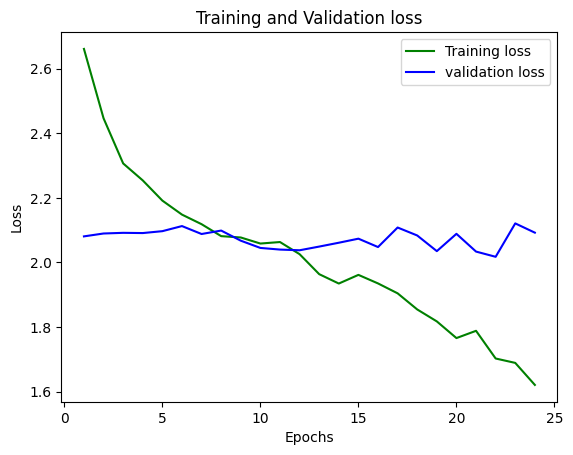

In [20]:
# Plot Training and validation loss
loss_train = history_VGGNet.history['loss']
loss_val = history_VGGNet.history['val_loss']
epochs = range(1,25)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

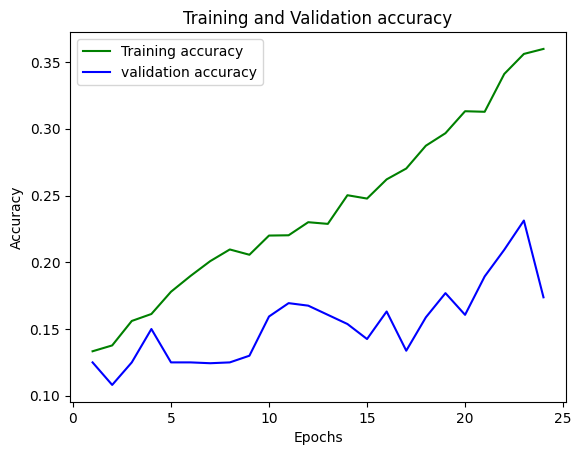

In [21]:
# Plot Training and validation accuracy
acc_train = history_VGGNet.history['accuracy']
acc_val = history_VGGNet.history['val_accuracy']
epochs = range(1,25)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

50/50 [==============================] - 1s 10ms/step


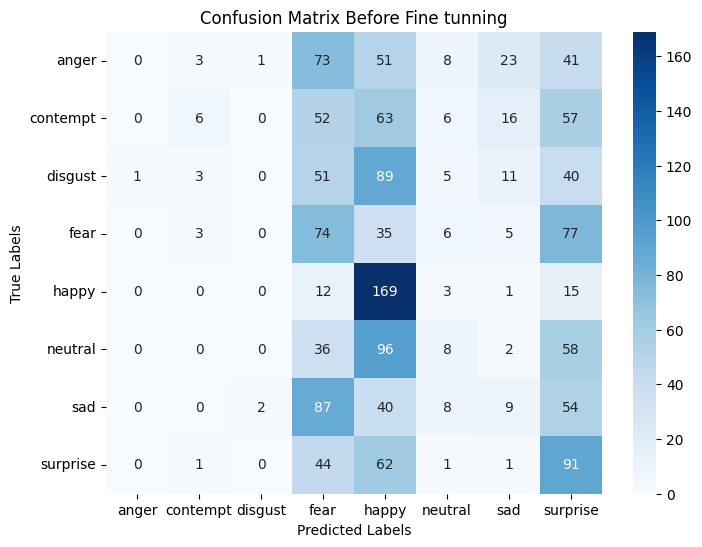

In [22]:
y_pred=VGGNet.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Before Fine tunning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       200
    contempt       0.38      0.03      0.06       200
     disgust       0.00      0.00      0.00       200
        fear       0.17      0.37      0.24       200
       happy       0.28      0.84      0.42       200
     neutral       0.18      0.04      0.07       200
         sad       0.13      0.04      0.07       200
    surprise       0.21      0.46      0.29       200

    accuracy                           0.22      1600
   macro avg       0.17      0.22      0.14      1600
weighted avg       0.17      0.22      0.14      1600



In [24]:
trained_model = load_model('VGGNet/checkpoint')

In [25]:
trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 128, 128, 16)      0

In [65]:
for layer in trained_model.layers:
  layer.trainable = False

In [66]:
layers_to_unfreeze = ['conv2d_9', 'batch_normalization_9', 'conv2d_8','batch_normalization_8','conv2d_7', 'batch_normalization_7']  # Add the names of the layers you want to unfreeze

# Unfreeze the specified layers
for layer in trained_model.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True


In [67]:
for layer in trained_model.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: conv2d, Trainable: False
Layer Name: batch_normalization, Trainable: False
Layer Name: activation, Trainable: False
Layer Name: conv2d_1, Trainable: False
Layer Name: batch_normalization_1, Trainable: False
Layer Name: activation_1, Trainable: False
Layer Name: max_pooling2d, Trainable: False
Layer Name: dropout, Trainable: False
Layer Name: conv2d_2, Trainable: False
Layer Name: batch_normalization_2, Trainable: False
Layer Name: activation_2, Trainable: False
Layer Name: conv2d_3, Trainable: False
Layer Name: batch_normalization_3, Trainable: False
Layer Name: activation_3, Trainable: False
Layer Name: max_pooling2d_1, Trainable: False
Layer Name: dropout_1, Trainable: False
Layer Name: conv2d_4, Trainable: False
Layer Name: batch_normalization_4, Trainable: False
Layer Name: activation_4, Trainable: False
Layer Name: conv2d_5, Trainable: False
Layer Name: batch_normalization_5, Trainable: False
Layer Name: activation_5, Trainable: False
Layer Name: max_pooling2d_2, Train

In [68]:
checkpoint_tune = ModelCheckpoint('tune/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [69]:
optimizer_tune = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [70]:
trained_model.compile(optimizer=optimizer_tune, loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
history_tune = trained_model.fit(X_tune , y_tune, validation_split=0.1, epochs=24, batch_size=32, callbacks=[checkpoint_tune], verbose = 1)

Epoch 1/24
45/45 [==============================] - ETA: 0s - loss: 0.7999 - accuracy: 0.7569
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to tune/checkpoint
45/45 [==============================] - 10s 164ms/step - loss: 0.7999 - accuracy: 0.7569 - val_loss: 3.2741 - val_accuracy: 0.0000e+00
Epoch 2/24
42/45 [===========================>..] - ETA: 0s - loss: 0.7897 - accuracy: 0.7723
Epoch 2: val_accuracy did not improve from 0.00000
45/45 [==============================] - 1s 19ms/step - loss: 0.7933 - accuracy: 0.7681 - val_loss: 2.8415 - val_accuracy: 0.0000e+00
Epoch 3/24
43/45 [===========================>..] - ETA: 0s - loss: 0.7722 - accuracy: 0.7791
Epoch 3: val_accuracy did not improve from 0.00000
45/45 [==============================] - 1s 18ms/step - loss: 0.7780 - accuracy: 0.7750 - val_loss: 3.1416 - val_accuracy: 0.0000e+00
Epoch 4/24
44/45 [============================>.] - ETA: 0s - loss: 0.7555 - accuracy: 0.7749
Epoch 4: val_accuracy improved fr

In [72]:
Tuned_model = load_model('tune/checkpoint')

loss, accuracy = Tuned_model.evaluate(X_test, y_test, verbose=2)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

50/50 - 1s - loss: 2.2302 - accuracy: 0.2512 - 935ms/epoch - 19ms/step

Testing loss: 2.23, accuracy: 25.12%


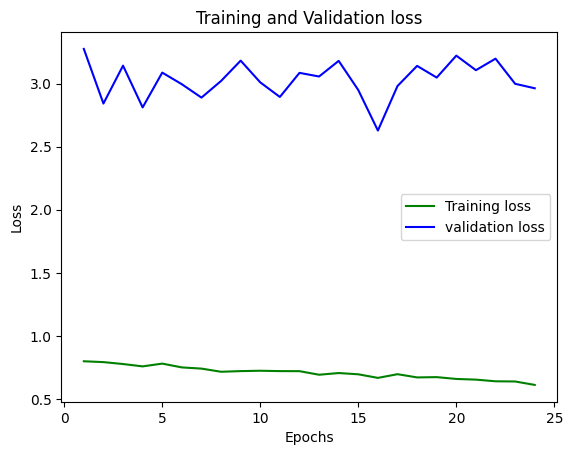

In [73]:
# Plot Training and validation loss
loss_train = history_tune.history['loss']
loss_val = history_tune.history['val_loss']
epochs = range(1,25)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

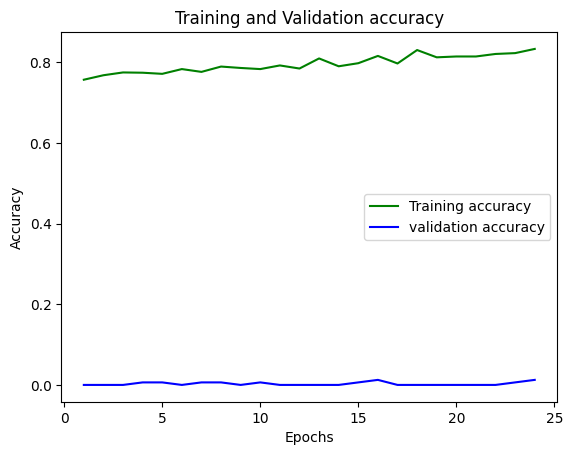

In [74]:
# Plot Training and validation accuracy
acc_train = history_tune.history['accuracy']
acc_val = history_tune.history['val_accuracy']
epochs = range(1,25)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

50/50 [==============================] - 1s 13ms/step


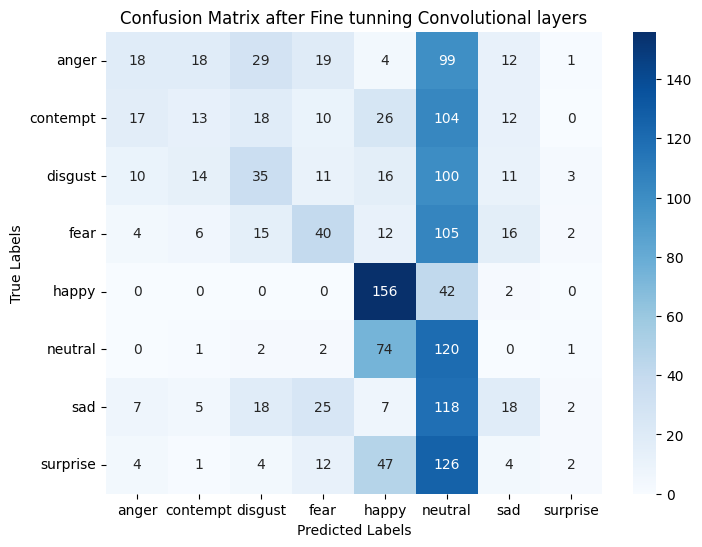

In [75]:
y_pred_tune = Tuned_model.predict(X_test)
y_pred_tune = np.argmax(y_pred_tune, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred_tune,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix after Fine tunning Convolutional layers')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [76]:
print(classification_report(y_true, y_pred_tune,target_names=labels))

              precision    recall  f1-score   support

       anger       0.30      0.09      0.14       200
    contempt       0.22      0.07      0.10       200
     disgust       0.29      0.17      0.22       200
        fear       0.34      0.20      0.25       200
       happy       0.46      0.78      0.58       200
     neutral       0.15      0.60      0.24       200
         sad       0.24      0.09      0.13       200
    surprise       0.18      0.01      0.02       200

    accuracy                           0.25      1600
   macro avg       0.27      0.25      0.21      1600
weighted avg       0.27      0.25      0.21      1600



50/50 [==============================] - 1s 13ms/step


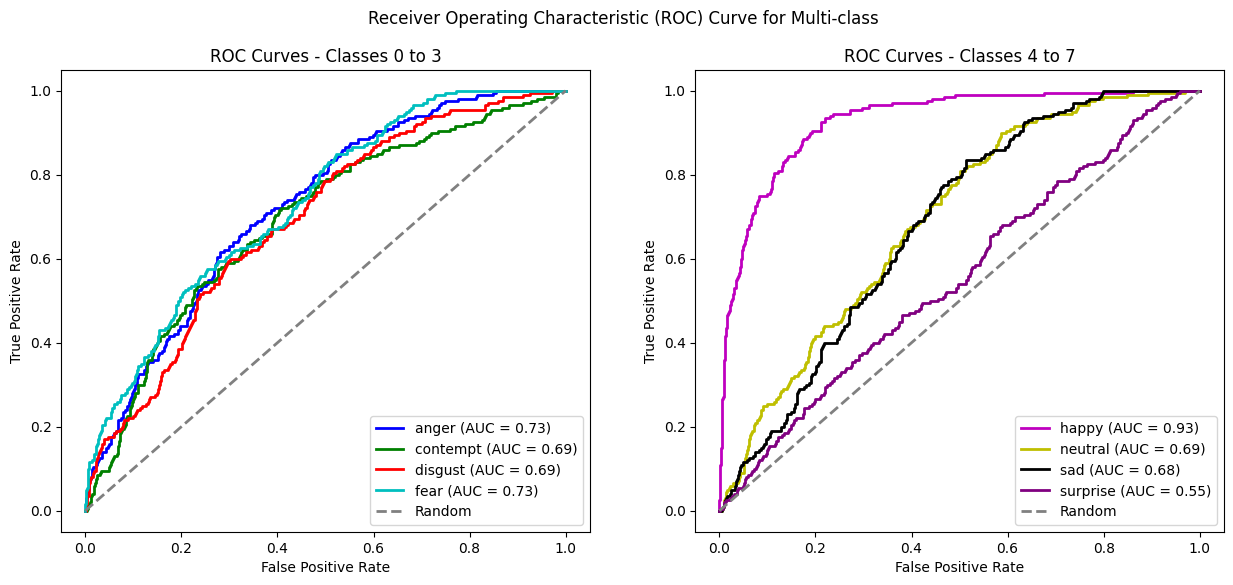

In [77]:
y_ROC = Tuned_model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Replace class indices with class labels
class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

for i, label in enumerate(class_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_ROC[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves in two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot
axs[0].set_title('ROC Curves - Classes 0 to 3')
colors = ['b', 'g', 'r', 'c']
for i, color in zip(range(4), colors):
    axs[0].plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

axs[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

# Second subplot
axs[1].set_title('ROC Curves - Classes 4 to 7')
colors = ['m', 'y', 'k', 'purple']
for i, color in zip(range(4, 8), colors):
    axs[1].plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

axs[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc="lower right")

plt.suptitle('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.show()